In [1]:
%cd ..
%cd ..
%cd ..

C:\Users\carlo\Documents\GitHub\FLOOD_group2\models\CNN_model
C:\Users\carlo\Documents\GitHub\FLOOD_group2\models
C:\Users\carlo\Documents\GitHub\FLOOD_group2


To run the cells in this notebook, the following .py files containing the functions and classes used in this assignment need to be imported.

In [2]:
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Preprocessing_Functions import *
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Class_Model import *
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Training_Functions import *
from models.CNN_model.Autoregressive_U_Net_Model.Autoregressive_U_Net_Prediction_Functions import *

<div align="center">

# INTRODUCTION

</div>

The objective of this Jupyter Notebook is to develop and train a deep learning model, specifically an Autoregressive U-Net style Convolutional Neural Network (CNN), to predict the progression of flooding resulting from a dike breach. The following sections will provide a detailed description of the model's architecture and functionality. This model incorporates morphological terrain features, including Digital Elevation Model (DEM) data, slope information in both horizontal and vertical directions, and the location of the dike breach, to make its predictions.

The GIF below demonstrates a sample from the dataset utilized for this task.

In [3]:
# create_water_depth_gif(file_id=4, start_time_step=1, end_time_step=96, fps=5)

<div align="center">

# METHODOLOGY

</div>

In this project, we were provided with pre-generated Digital Elevation Models (DEMs) that were created using a random digital elevation model generator based on the Perlin noise algorithm (Perlin, 2002). This method is known for producing topographies that closely resemble realistic landscapes. 

Based on the DEM, the slopes in the horizontal and vertical directions were computed using the central difference method, wherein the derivative at each grid point is approximated by the difference between its immediate neighboring points in the respective direction.

The water depth targets in our datasets were sourced from high-fidelity simulations using Delft3D-FM, a numerical solver by Deltares (2022). This software accurately solves the full shallow water equations using an implicit scheme on staggered grids and adaptive time steps.

<div align="center">

## Creation of the Training and Validation Datasets

</div>

In the following code cells, we focus on the development of training and validation datasets. Our dataset comprises 80 samples, each containing a Digital Elevation Model (DEM), a computed slopes raster, and water depth simulations spanning two days. These simulations are originally segmented into 96 time steps, each step representing a 30-minute interval. However, for our analysis, we selected only 48 time steps at intervals of two, which is equivelant to capturing water depth data every hour of the simulation.

### 1) Prepare the dataset to be splitted into training and validation datasets

In [4]:
complete_dataset_list = []


for file_id in range(1, 81):  # Loops through all the DEM file IDs that are numbered from 1 to 80 (training and validation files)
    elevation_slope_tensor = process_elevation_data_for_training(file_id).double()  # Shape: [3, 64, 64]
    
    # Initialize a list to store water depth tensors for all time steps
    target_tensors = []

    # Loop through all 96 time steps to collect water depth data using a step of 2
    for n in range(0, 96, 8):
        water_depth_tensor = process_water_depth_for_training(file_id, time_step=n).double()  # Shape: [64, 64]
        target_tensors.append(water_depth_tensor)

    # Stack all target tensors to create a single tensor
    targets_tensor = torch.stack(target_tensors)

    # Create a dictionary for each sample to seperate inputs from targets
    sample = {"inputs": elevation_slope_tensor, "targets": targets_tensor}

    # Append the sample dictionary to the complete dataset list
    complete_dataset_list.append(sample)

In [5]:
# Check the size (shape) of complete_dataset_list
first_sample = complete_dataset_list[0]
print("Shape of inputs:", first_sample['inputs'].shape)
print("Shape of targets:", first_sample['targets'].shape)

# Get the total number of samples in complete_dataset_list
num_train_samples = len(complete_dataset_list)
print("Total number of samples in the dataset:", num_train_samples)

Shape of inputs: torch.Size([3, 64, 64])
Shape of targets: torch.Size([12, 64, 64])
Total number of samples in the dataset: 80


### 2) Split dataset into train and validation

In the upcoming code, we have chosen to divide the previously created dataset, allocating 80% for training and 20% for validation purposes. A separate dataset, comprising different samples, will be developed later for testing.

In [6]:
train_percnt = 0.8
train_size = int(train_percnt * len(complete_dataset_list))
val_size = len(complete_dataset_list) - train_size
train_dataset, val_dataset = random_split(complete_dataset_list, [train_size, val_size])

In [7]:
# Check the size (shape) of the first sample in train_dataset
first_sample = train_dataset[0]
print("Shape of inputs in the training samples:", first_sample['inputs'].shape)
print("Shape of targets in the training samples:", first_sample['targets'].shape)

# Get the total number of samples in train_dataset
num_train_samples = len(train_dataset)
print("Total number of samples in the training dataset:", num_train_samples)

Shape of inputs in the training samples: torch.Size([3, 64, 64])
Shape of targets in the training samples: torch.Size([12, 64, 64])
Total number of samples in the training dataset: 64


In [8]:
# Check the size (shape) of the first sample in val_dataset
first_sample = val_dataset[0]
print("Shape of inputs in the validation samples:", first_sample['inputs'].shape)
print("Shape of targets in the validation samples:", first_sample['targets'].shape)

# Get the total number of samples in val_dataset
num_train_samples = len(val_dataset)
print("Total number of samples in the validation dataset:", num_train_samples)

Shape of inputs in the validation samples: torch.Size([3, 64, 64])
Shape of targets in the validation samples: torch.Size([12, 64, 64])
Total number of samples in the validation dataset: 16


### 3) Normalization

In the following code, we opted to normalize the dataset using the  Min-Max scaling technique. This method subtracts the minimum value of the data and then dividing by the range. This way, the smallest value becomes 0, the largest value becomes 1, and all other values are transformed to some decimal between 0 and 1, maintaining their proportional relationship to each other.

In [9]:
# Initialize scalers
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit the scalers using only the training dataset
for i in range(len(train_dataset)):
    sample = train_dataset[i]
    inputs = sample['inputs'].reshape(-1, 1).cpu()
    targets = sample['targets'].reshape(-1, 1).cpu()
    scaler_x.partial_fit(inputs)
    scaler_y.partial_fit(targets)

# Normalize the datasets
normalized_train_dataset = [normalize_sample(train_dataset[i], scaler_x, scaler_y) for i in range(len(train_dataset))]
normalized_val_dataset = [normalize_sample(val_dataset[i], scaler_x, scaler_y) for i in range(len(val_dataset))]

### 4) Prepare train dataset for the training of the autoregressive model

In the following code, we prepared the train dataset for the training of the autoregressive model. For an autoregressive model, which predicts future values based on past values, it's essential to structure the data so that each input includes past information necessary for prediction. Therefore, we created an inner loop that runs through the time steps of each sample, adjusting for future predictions. For each time step, it creates a new input tensor that combines the elevation and slope data with the current water depth. The corresponding output tensor is then constructed from the water depths at the next two time steps. 

We chose to predict the water depth for the next two periods because this approach helps mitigate the issue of error propagation that is common in autoregressive models. This training method will be explained in more detail later.

In [10]:
normalized_autoregressive_train_dataset = []

# Loop through each sample in the train_dataset Subset
for i in range(len(normalized_train_dataset)):
    # Extract the sample directly from train_dataset
    sample = normalized_train_dataset[i]
    
    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    # The number of time steps is the size of the first dimension of water_depths
    num_time_steps = water_depths.shape[0]

    # Loop through the time steps, leaving room for n+1 and n+2
    for n in range(num_time_steps - 2):
        # Current time step water depth
        water_depth_n = water_depths[n].unsqueeze(0).float()

        # Create the new input tensor
        input_tensor = torch.cat((elevation_slope_tensor, water_depth_n), dim=0)  # Shape: [4, 64, 64]

        # Create the output tensor for time steps n+1 and n+2
        output_tensor = water_depths[n+1:n+3].float()  # Shape: [2, 64, 64]

        # Append to the new autoregressive train dataset
        normalized_autoregressive_train_dataset.append((input_tensor, output_tensor))

In [11]:
# Check the size (shape) of the first sample in normalized_autoregressive_train_dataset
print("Shape of inputs in the training samples after preparation:", input_tensor.shape)
print("Shape of targets in the training samples after preparation:", output_tensor.shape)

# Get the total number of samples in normalized_autoregressive_train_dataset
num_train_samples = len(normalized_autoregressive_train_dataset)
print("Total number of samples in the training dataset after preparation:", num_train_samples)

Shape of inputs in the training samples after preparation: torch.Size([4, 64, 64])
Shape of targets in the training samples after preparation: torch.Size([2, 64, 64])
Total number of samples in the training dataset after preparation: 640


### 5) Prepare validation dataset for evaluation

The validation dataset was prepared for training in such a way that each of the 16 samples includes all 48 water depths predictions as targets. This configuration will be important when computing the validation loss, as discussed later.

In [12]:
normalized_autoregressive_val_dataset = []

# Loop through each sample in the train_dataset Subset
for sample in normalized_val_dataset:

    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    # Loop through the time steps, leaving room for n+1 and n+2
    input_tensor = torch.cat((elevation_slope_tensor, water_depths[0].unsqueeze(0)), dim=0)  # Shape: [1, 4, 64, 64]

    sample = {"inputs": input_tensor, "targets": water_depths}

    normalized_autoregressive_val_dataset.append(sample)

In [13]:
# Check the size (shape) of the first sample in normalized_autoregressive_val_dataset
first_sample = normalized_autoregressive_val_dataset[0]
print("Shape of inputs in the validatiomn samples after preparation:", first_sample['inputs'].shape)
print("Shape of targets in the validation samples after preparation:", first_sample['targets'].shape)

# Get the total number of samples in normalized_autoregressive_val_dataset
num_train_samples = len(normalized_autoregressive_val_dataset)
print("Total number of samples in the validation dataset after preparation:", num_train_samples)

Shape of inputs in the validatiomn samples after preparation: torch.Size([4, 64, 64])
Shape of targets in the validation samples after preparation: torch.Size([12, 64, 64])
Total number of samples in the validation dataset after preparation: 16


<div align="center">

## Creation of the Testing Datasets

</div>

In this notebook, we assess the generalization of the model's predictions using two different testing datasets. The first test dataset contains data where the dike breach is in the same location as the samples in the training dataset. In the second test dataset, the dike breach location varies across the boundaries of the domain.

### 1) Testing Dataset 1

In [14]:
test_dataset_1_list = []

for file_id in range(500, 520):  # Loops through all the file IDs that are numbered from 500 to 520 (test dataset 1)
    # Process elevation data as input
    elevation_slope_tensor = process_elevation_data_for_testing_dataset_1(file_id).double()  # Shape: [3, 64, 64]

    # Initialize a list to store water depth tensors for all future time steps
    target_tensors = []

    # Loop through all time steps to collect water depth data
    for n in range(0, 96, 8):  # Assuming there are 96 time steps in total
        water_depth_tensor = process_water_depth_for_testing_dataset_1(file_id, time_step=n).double()  # Shape: [64, 64]
        target_tensors.append(water_depth_tensor)

    # Stack all target tensors to create a single tensor with shape: [96, 64, 64]
    targets_tensor = torch.stack(target_tensors)  # Shape: [96, 64, 64]

    # Create a dictionary for each sample
    sample = {"inputs": elevation_slope_tensor, "targets": targets_tensor}

    # Append the sample dictionary to the complete dataset list
    test_dataset_1_list.append(sample)

In [15]:
# Check the size (shape) of the first sample in test_dataset_list
first_sample = test_dataset_1_list[0]
print("Shape of inputs in the test samples:", first_sample['inputs'].shape)
print("Shape of targets in the test samples:", first_sample['targets'].shape)

# Get the total number of samples in test_dataset_list
num_train_samples = len(test_dataset_1_list)
print("Total number of samples in the test dataset:", num_train_samples)

Shape of inputs in the test samples: torch.Size([3, 64, 64])
Shape of targets in the test samples: torch.Size([12, 64, 64])
Total number of samples in the test dataset: 20


#### 1.1) Normalization

We have used the Min-Max scaling technique to normalize the data. This is the same method used for normalizing the training and validation datasets.

In [16]:
normalized_test_dataset_1 = [normalize_sample(test_dataset_1_list[i], scaler_x, scaler_y) for i in range(len(test_dataset_1_list))]

#### 1.2) Prepare Test Dataset 1 to be used to make predictions

We prepared the first test dataset for making predictions by creating four input channels: DEM, slope in the horizontal and vertical directions, and water depth at the first time step of the simulation. This initial water depth serves as the initial condition of the problem, as the only non-zero values are in the location of the dike breach. As targets, we used all 48 time steps of water depth that we aim to predict.

In [17]:
normalized_autoregressive_test_dataset_1 = []

# Loop through each sample in the train_dataset Subset
for sample in normalized_test_dataset_1:

    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    input_tensor = torch.cat((elevation_slope_tensor, water_depths[0].unsqueeze(0)), dim=0)  # Shape: [1, 4, 64, 64]

    sample = {"inputs": input_tensor, "targets": water_depths}

    normalized_autoregressive_test_dataset_1.append(sample)

In [18]:
# Check the size (shape) of the first sample in normalized_autoregressive_test_dataset_1
first_sample = normalized_autoregressive_test_dataset_1[0]
print("Shape of inputs in the test samples after preparation:", first_sample['inputs'].shape)
print("Shape of targets in the test samples afterm preparation:", first_sample['targets'].shape)

# Get the total number of samples in normalized_autoregressive_test_dataset_1
num_train_samples = len(normalized_autoregressive_test_dataset_1)
print("Total number of samples in the test dataset after preparation:", num_train_samples)

Shape of inputs in the test samples after preparation: torch.Size([4, 64, 64])
Shape of targets in the test samples afterm preparation: torch.Size([12, 64, 64])
Total number of samples in the test dataset after preparation: 20


### 2) Testing Dataset 2

In [19]:
test_dataset_2_list = []

for file_id in range(10000, 10020):  # Loops through all the file IDs that are numbered from 10000 to 10020 (test dataset 2)
    # Process elevation data as input
    elevation_slope_tensor = process_elevation_data_for_testing_dataset_2(file_id).double()  # Shape: [3, 64, 64]

    # Initialize a list to store water depth tensors for all future time steps
    target_tensors = []

    # Loop through all time steps to collect water depth data
    for n in range(0, 96, 8):  # Assuming there are 96 time steps in total
        water_depth_tensor = process_water_depth_for_testing_dataset_2(file_id, time_step=n).double()  # Shape: [64, 64]
        target_tensors.append(water_depth_tensor)

    # Stack all target tensors to create a single tensor with shape: [96, 64, 64]
    targets_tensor = torch.stack(target_tensors)  # Shape: [96, 64, 64]

    # Create a dictionary for each sample
    sample = {"inputs": elevation_slope_tensor, "targets": targets_tensor}

    # Append the sample dictionary to the complete dataset list
    test_dataset_2_list.append(sample)

In [20]:
# Check the size (shape) of the first sample in test_dataset_list_2
first_sample = test_dataset_2_list[0]
print("Shape of inputs in the test samples:", first_sample['inputs'].shape)
print("Shape of targets in the test samples:", first_sample['targets'].shape)

# Get the total number of samples in test_dataset_list_2
num_train_samples = len(test_dataset_2_list)
print("Total number of samples in the test dataset:", num_train_samples)

Shape of inputs in the test samples: torch.Size([3, 64, 64])
Shape of targets in the test samples: torch.Size([12, 64, 64])
Total number of samples in the test dataset: 20


#### 2.1) Normalization

We have used the Min-Max scaling technique to normalize the data. This is the same method used for normalizing the training and validation datasets.

In [21]:
normalized_test_dataset_2 = [normalize_sample(test_dataset_2_list[i], scaler_x, scaler_y) for i in range(len(test_dataset_2_list))]

#### 2.2) Prepare Test Dataset 2 to be used to make predictions

We prepared the second test dataset for making predictions in the same way as we prepared the first one.

In [22]:
normalized_autoregressive_test_dataset_2 = []

# Loop through each sample in the train_dataset Subset
for sample in normalized_test_dataset_2:

    # Unpack the existing input (elevation and slopes) and targets (water depths)
    elevation_slope_tensor, water_depths = sample['inputs'], sample['targets']

    input_tensor = torch.cat((elevation_slope_tensor, water_depths[0].unsqueeze(0)), dim=0)  # Shape: [1, 4, 64, 64]

    sample = {"inputs": input_tensor, "targets": water_depths}

    normalized_autoregressive_test_dataset_2.append(sample)

In [23]:
# Check the size (shape) of the first sample in normalized_autoregressive_test_dataset_2
first_sample = normalized_autoregressive_test_dataset_2[0]
print("Shape of inputs in the test samples after preparation:", first_sample['inputs'].shape)
print("Shape of targets in the test samples afterm preparation:", first_sample['targets'].shape)

# Get the total number of samples in normalized_autoregressive_test_dataset_2
num_train_samples = len(normalized_autoregressive_test_dataset_2)
print("Total number of samples in the test dataset after preparation:", num_train_samples)

Shape of inputs in the test samples after preparation: torch.Size([4, 64, 64])
Shape of targets in the test samples afterm preparation: torch.Size([12, 64, 64])
Total number of samples in the test dataset after preparation: 20


# 3) U-Net Model

The U-Net is a Convolutional Neural Network (CNN) model that was first introduced by Ronneberger et al. (2015) for biomedical image segmentation. This architecture, with its encoder/decoder structure, is particularly well-suited for applications that require the capture and reconstruction of spatial details, such as predicting water depths for subsequent time steps after a dike breach. This task necessitates the use of input rasters stored as 64 x 64 grids for flood predictions, also in 64 x 64 grid format. U-Net's encoder efficiently compresses these inputs with convolutional and downsampling operations, capturing essential features and storing them in the latent space, where the values held have abstract meaning. Meanwhile, the decoder part, using convolutional and upsampling operations, reconstructs the spatial details needed for flood progression predictions.

Moreover, U-Net incorporates skip connections that bridge corresponding layers in the encoder and decoder. These connections are crucial for the preservation of fine details in the predicted water depth maps, as they allow the direct flow of gradient information between encoder and decoder layers, enhancing training stability and model performance.


Finally, as a fully convolutional neural network, U-Net can process images of varying sizes. Therefore, the model could handle also inputs and make predictions with different grid size besides 64 x 64, enabling different data augmentation procedures. However, this capability was not explored during this assignemnet since we only feed and predicts 64 x 64 grids.

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the CNN
model = UNet().to(device)
summary(model, input_size=(4, 64, 64))  # Replace with your input size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 64, 64]             288
       BatchNorm2d-2            [-1, 8, 64, 64]              16
              ReLU-3            [-1, 8, 64, 64]               0
            Conv2d-4            [-1, 8, 64, 64]             576
       BatchNorm2d-5            [-1, 8, 64, 64]              16
              ReLU-6            [-1, 8, 64, 64]               0
        DoubleConv-7            [-1, 8, 64, 64]               0
         MaxPool2d-8            [-1, 8, 32, 32]               0
            Conv2d-9           [-1, 16, 32, 32]           1,152
      BatchNorm2d-10           [-1, 16, 32, 32]              32
             ReLU-11           [-1, 16, 32, 32]               0
           Conv2d-12           [-1, 16, 32, 32]           2,304
      BatchNorm2d-13           [-1, 16, 32, 32]              32
             ReLU-14           [-1, 16,

# 4) Training

Autoregressive models suffer from exposure bias, a phenomenon arising due to a discrepancy between how a model is trained and how it is used at inference time. For instance, during training, this model employs a technique known as teacher forcing, where it is trained to predict water depths for the next time step given the true previous water depths. 

However, during inference, the model predicts the water depth one time step at a time, feeding its own predictions back as input for generating subsequent time steps. This discrepancy means that the model is never trained on its own errors. 

Consequently, this issue leads to error propagation, meaning that when the model generates water depths auto-regressively during inference and makes an error at some point, this error can affect the generation of all subsequent water depths. This type of error is well documented in the literature, specially in neural machine translation applications (Wu et al., 2018, Shen et al., 2016).

To mitigate this issue, the function below performs loss accumulation across two steps using the Mean Squared Error (MSE). By updating the input tensor (x_updated) with the model's own predictions (preds) before making a second prediction, we aim to teach the model to correct itself after making an initial prediction, potentially reducing the impact of any initial errors on subsequent predictions. This approach enhances the model's resilience against the accumulation of errors across a sequence of predictions, which is a direct strategy to combat both exposure bias and error propagation.

For evaluation we computed the 

In [25]:
# Set training parameters
learning_rate = 0.0001
batch_size = 32
num_epochs = 25

# Create the optimizer to train the neural network via back-propagation
optimizer = torch.optim.Adam(params=model.parameters(), lr=learning_rate)

# Create the training and validation dataloaders to "feed" data to the model in batches
train_loader = DataLoader(normalized_autoregressive_train_dataset, batch_size=batch_size, shuffle=True)
# Create DataLoader for validation dataset
val_data = CustomDataset(normalized_autoregressive_val_dataset)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

In [26]:
train_losses = []
validation_losses = []

# Training loop
for epoch in range(num_epochs):
    # Training loop
    train_loss = train_epoch(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)

    # Validation loop
    validation_loss = evaluation(model, val_loader, device=device)
    validation_losses.append(validation_loss)

    print(f'Epoch {epoch+1}', f'Train Loss: {train_losses[-1]}', f'Validation Loss: {validation_losses[-1]}')

Epoch 1 Train Loss: 0.011419549584388733 Validation Loss: 0.005961408838629723
Epoch 2 Train Loss: 0.008998971432447433 Validation Loss: 0.005955379921942949
Epoch 3 Train Loss: 0.006550618913024664 Validation Loss: 0.005957268178462982
Epoch 4 Train Loss: 0.004985612817108631 Validation Loss: 0.005952672567218542
Epoch 5 Train Loss: 0.003629776882007718 Validation Loss: 0.00594535144045949
Epoch 6 Train Loss: 0.0027201783377677202 Validation Loss: 0.005931887309998274
Epoch 7 Train Loss: 0.002183215692639351 Validation Loss: 0.005869542248547077
Epoch 8 Train Loss: 0.0019049845868721604 Validation Loss: 0.005866559222340584
Epoch 9 Train Loss: 0.0017555246595293283 Validation Loss: 0.005865581799298525
Epoch 10 Train Loss: 0.0016501236241310835 Validation Loss: 0.005899269599467516
Epoch 11 Train Loss: 0.0015567298978567123 Validation Loss: 0.005925090983510017
Epoch 12 Train Loss: 0.0015097504947334528 Validation Loss: 0.005951006431132555
Epoch 13 Train Loss: 0.001433091820217669 Va

<div align="center">

# RESULTS

</div>

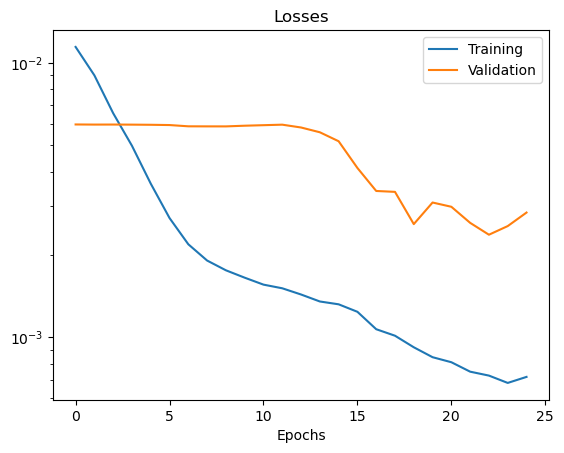

In [28]:
plt.plot(train_losses, label='Training')
plt.plot(validation_losses, label='Validation')
plt.yscale('log')
plt.title('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Model Predictions

## 1) Test Dataset 1

### 1.1) Making autoregressive predictions

In [29]:
file_id = 10
inputs = normalized_autoregressive_test_dataset_1[file_id]['inputs'] # torch.Size([4, 64, 64])
targets = normalized_autoregressive_test_dataset_1[file_id]['targets'] # torch.Size([12, 64, 64])

# Set the model to evaluation mode to make predictions faster
model.eval()

# Add batch dimension and send to the same device as the model
input_tensor = inputs.unsqueeze(0).float().to(device)

predictions = []
for real_WD in targets[1:]:
    with torch.no_grad():
        # Make a prediction
        
        pred_WD = model(input_tensor) # output = torch.Size([1, 1, 64, 64])
        
        pred_WD_denormalized = scaler_y.inverse_transform(pred_WD.reshape(-1,1).cpu()).reshape(64,64)
        real_WD_denormalized = scaler_y.inverse_transform(real_WD.reshape(-1,1).cpu()).reshape(64,64)
        
        predictions.append((input_tensor[:, 0, :, :].cpu().numpy(), real_WD_denormalized, pred_WD_denormalized.squeeze()))
        
        # Update the input tensor with the current prediction to make the new prediction in the next iteration
        input_tensor = torch.cat((input_tensor[:, :3, :, :], pred_WD), dim=1)

### 1.2) Plotting predictions for a specific time step

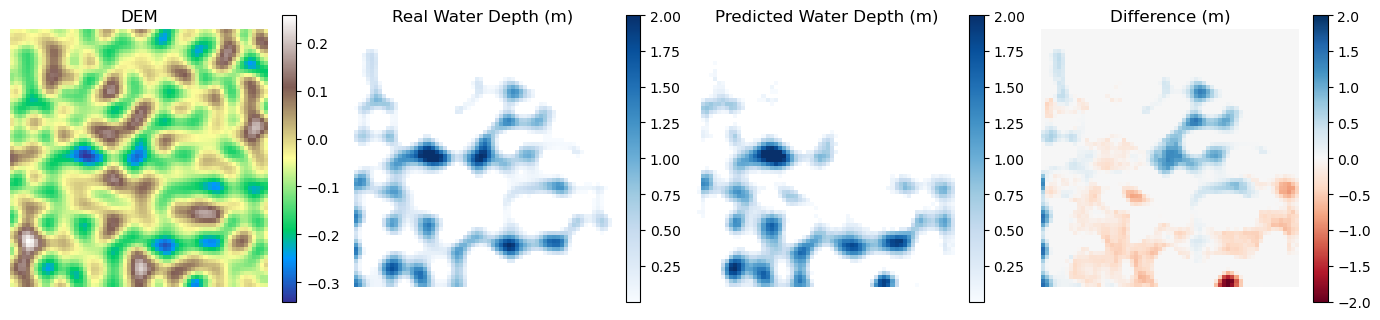

In [30]:
time_step = 10 # Select a time step to do the plot
plot_water_depth_comparison(predictions[time_step][0], predictions[time_step][1], predictions[time_step][2])

### 1.3) Creating a GIF of flood progression based on the predictions

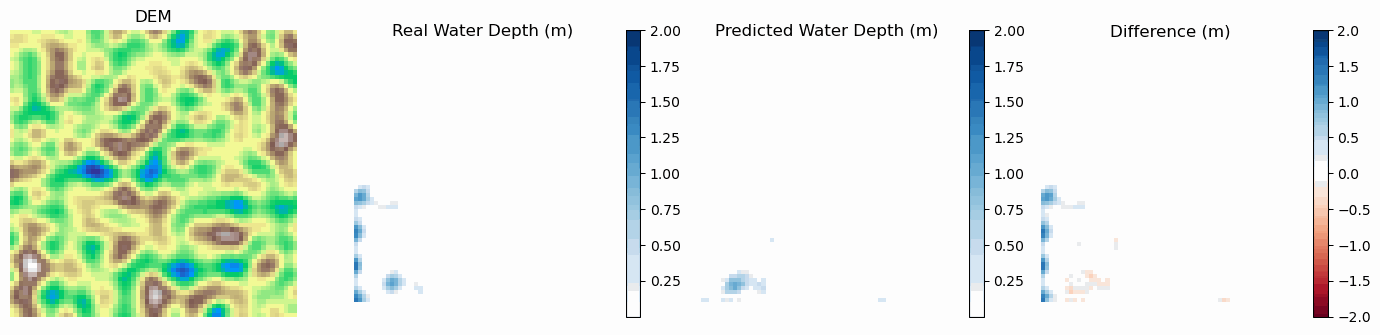

In [44]:
# Adjust duration to control the speed of the GIF
create_gif_from_preds_and_show(predictions, 'water_depth_comparison.gif', duration=0.0001)

## 2) Test Dataset 2

In [41]:
file_id = 10
inputs = normalized_autoregressive_test_dataset_2[file_id]['inputs'] # torch.Size([4, 64, 64])
targets = normalized_autoregressive_test_dataset_2[file_id]['targets'] # torch.Size([12, 64, 64])

# Set the model to evaluation mode to make predictions faster
model.eval()

# Add batch dimension and send to the same device as the model
input_tensor = inputs.unsqueeze(0).float().to(device)

predictions_2 = []
for real_WD in targets[1:]:
    with torch.no_grad():
        # Make a prediction
        
        pred_WD = model(input_tensor) # output = torch.Size([1, 1, 64, 64])
        
        pred_WD_denormalized = scaler_y.inverse_transform(pred_WD.reshape(-1,1).cpu()).reshape(64,64)
        real_WD_denormalized = scaler_y.inverse_transform(real_WD.reshape(-1,1).cpu()).reshape(64,64)
        
        predictions_2.append((input_tensor[:, 0, :, :].cpu().numpy(), real_WD_denormalized, pred_WD_denormalized.squeeze()))
        
        # Update the input tensor with the current prediction to make the new prediction in the next iteration
        input_tensor = torch.cat((input_tensor[:, :3, :, :], pred_WD), dim=1)

### 2.2) Plotting predictions for a specific time step

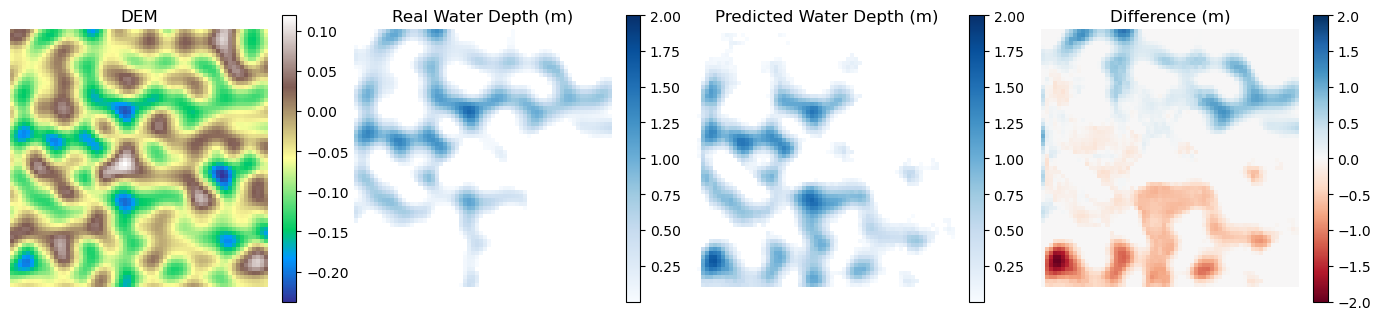

In [42]:
time_step = 10 # Select a time step to do the plot
plot_water_depth_comparison(predictions_2[time_step][0], predictions_2[time_step][1], predictions_2[time_step][2])

### 2.3) Creating a GIF of flood progression based on the predictions

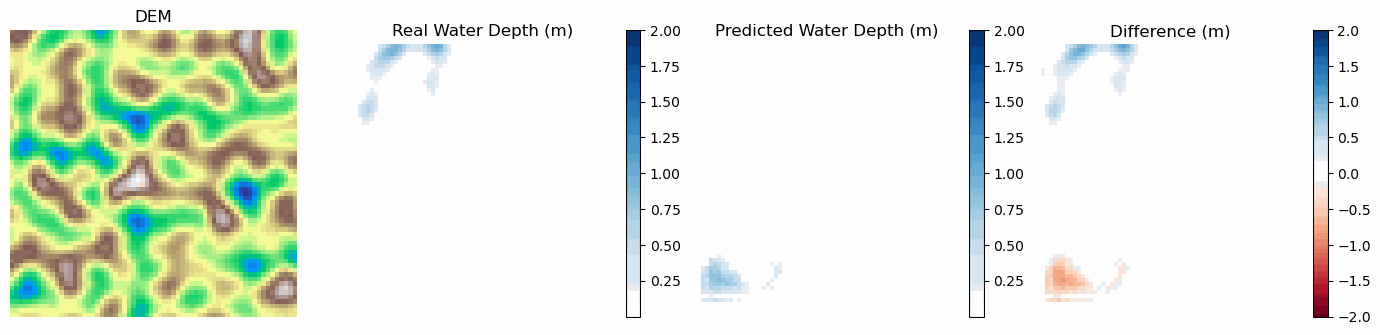

In [45]:
create_gif_from_preds_and_show(predictions_2, 'water_depth_comparison.gif', duration=0.0001)  # Adjust `duration` as needed

<div align="center">

# REFERENCE

</div>

Deltares. (2022) Delft3D-FM User Manual, https://content.oss.deltares.nl/delft3d/manuals/D-Flow_FM_User_Manual.pdf.
do Lago, C. A., Giacomoni, M. H., Bentivoglio, R., Taormina, R., Gomes, M. N., and Mendiondo, E. M.: Generalizing rapid
flood predictions to unseen urban catchments with conditional generative adversarial networks, Journal of Hydrology, p. 129276,
https://doi.org/https://doi.org/10.1016/j.jhydrol.2023.129276, 2023.

Perlin, K. (2012). Improving noise, in: Proceedings of the 29th annual conference on Computer graphics and interactive techniques, pp. 681–682, 2002.

Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. (2015). "U-net: Convolutional networks for biomedical image segmentation." Medical Image Computing and Computer-Assisted Intervention–MICCAI 2015: 18th International Conference, Munich, Germany, October 5-9, 2015, Proceedings, Part III 18. Springer International Publishing.

Shiqi Shen, Yong Cheng, Zhongjun He, Wei He, Hua Wu, Maosong Sun, and Yang Liu. 2016. Minimum risk training for neural machine translation. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics, ACL 2016, August 7-12, 2016, Berlin, Germany, Volume 1: Long Papers.

Wu, L., Tan, X., He, D., Tian, F., Qin, T., Lai, J., & Liu, T. Y. (2018). Beyond error propagation in neural machine translation: Characteristics of language also matter. arXiv preprint arXiv:1809.00120.
